In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = [5000, 10000, 30000, 50000, 70000]
RUN_NAME = "vocab"

INFOLDER = "out_vocab"
RUN_END_FILTER = "r1763_t5"
run_folders = sorted([x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)],
                key = lambda x: int(x.split("_")[1]))
LIMIT = "full"

SEQ_LEN = 512

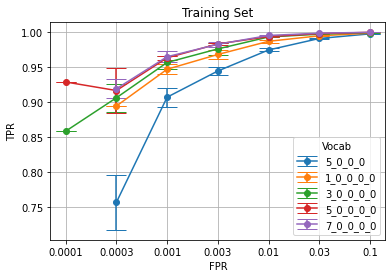

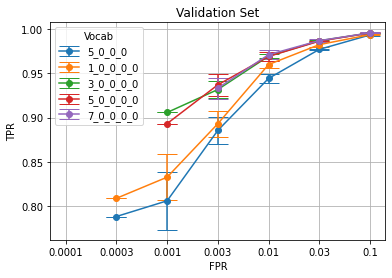

In [2]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
models = defaultdict(dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"nebula_vocab_{run_type}_seqlen_{SEQ_LEN}", f"tokenizer_{run_type}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }

In [4]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in sorted(run_folders, key = lambda x: int(x.split("_")[1])):
    key = int(folder.split("_")[1])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
5000,0.584883,0.665740,0.807775,0.892314,0.942940,0.977979,0.993236,0.998678,0.996529,0.981697,0.981926,0.981478,0.975252
10000,0.338563,0.663237,0.783441,0.894491,0.958741,0.981810,0.993742,0.998639,0.996942,0.983904,0.986065,0.981753,0.978194
30000,0.435919,0.591363,0.857612,0.933590,0.969467,0.986725,0.995141,0.999087,0.997703,0.986056,0.986841,0.985277,0.981137
50000,0.224594,0.655140,0.838282,0.930866,0.967483,0.985540,0.995413,0.998950,0.997616,0.985633,0.985326,0.985948,0.980585
70000,0.217919,0.596536,0.840686,0.938966,0.970416,0.986802,0.995393,0.999048,0.997733,0.986253,0.986492,0.986015,0.981412


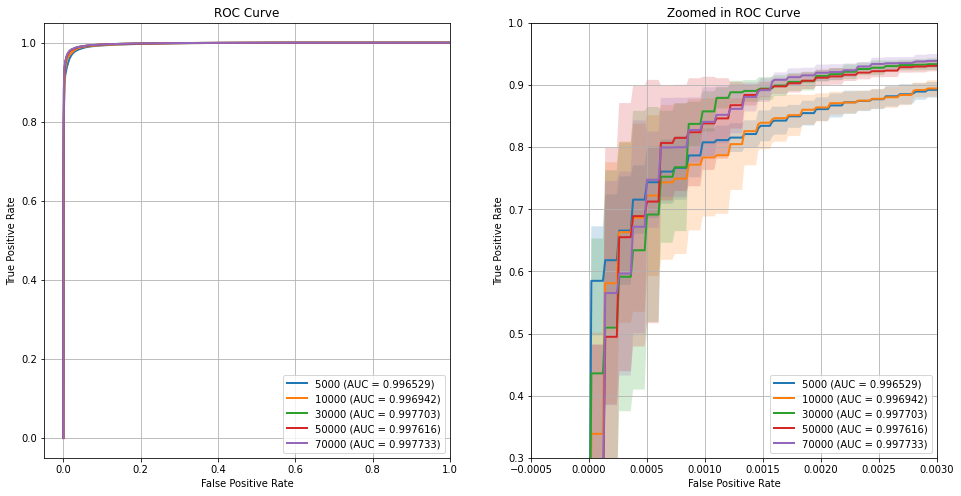

In [5]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [6]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = int(folder.split("_")[1])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if f"vocab_{key}_" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96,
                device=device
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
5000,0.179269,0.354993,0.519302,0.592506,0.672197,0.763338,0.881846,0.953809,0.956344,0.871063,0.801694,0.953681,0.871814
10000,0.254706,0.337942,0.530717,0.634939,0.755539,0.833918,0.899607,0.963026,0.966637,0.906030,0.864901,0.951385,0.903066
30000,0.282640,0.395441,0.533872,0.690063,0.785778,0.851537,0.916374,0.972775,0.972158,0.909467,0.860045,0.964994,0.907547
50000,0.306214,0.416676,0.599348,0.719274,0.801588,0.859867,0.916551,0.963558,0.970731,0.915402,0.870148,0.965965,0.913177
70000,0.277465,0.388918,0.583005,0.695984,0.782162,0.850190,0.903790,0.961998,0.967594,0.909542,0.861923,0.962987,0.907470


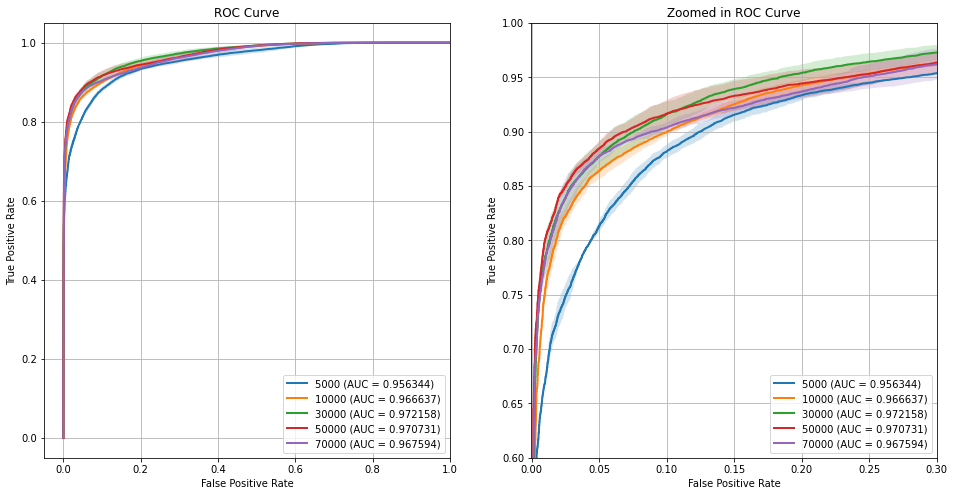

In [7]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

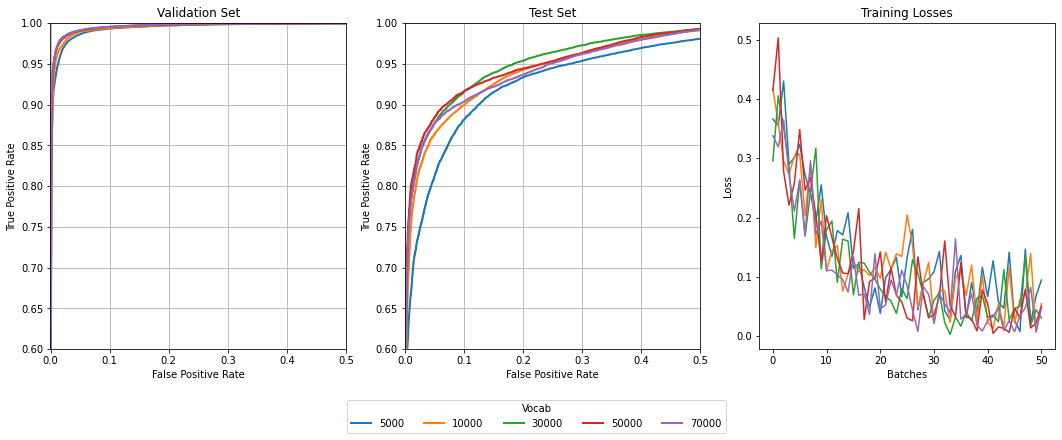

In [8]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 100
n = 50
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')

In [11]:
import scienceplots
plt.style.use(['science','no-latex'])

def plot_mean_std(metrics, field_idx, ax=None, title="", ylabel="", xlabel="", color=None, linetype=None, ylim=None, xlim=None):
    # metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
    # plot the mean and std of AUCs in lineplot with scatter points
    means = {}
    stds = {}
    for key in metrics:
        aucs = [x[field_idx] for x in metrics[key]]
        aucs_mean = np.mean(aucs)
        aucs_std = np.std(aucs)
        means[key] = aucs_mean
        stds[key] = aucs_std

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.errorbar(
        [int(x) for x in means.keys()],
        [float(x) for x in means.values()],
        yerr=[float(x) for x in stds.values()],
        capsize=5,
        # add label
        label=f"{ylabel}",
        # add color
        color=color,
        # add linestyle
        linestyle=linetype,
    )
    ax.scatter(
        [int(x) for x in means.keys()],
        [float(x) for x in means.values()],
        # add color
        color=color,
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    # place xlabels on the middle of the bars
    ax.set_xticks([int(x) for x in means.keys()])
    ax.set_xticklabels([int(x) for x in means.keys()])
    return ax

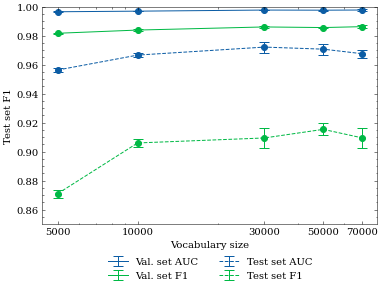

In [28]:
# make 2 subplots in one row
xlabel = "Vocabulary size"
fig, axs = plt.subplots(1, 1, figsize=(6,4))
_ = plot_mean_std(metrics_val, 2, title="", ylabel="Val. set AUC", xlabel=xlabel, ax=axs)
_ = plot_mean_std(metrics_val, 3, title="", ylabel="Val. set F1", xlabel=xlabel, ax=axs)
handles, labels = axs.get_legend_handles_labels()
color_auc = handles[0][0].get_color()
color_f1 = handles[1][0].get_color()
_ = plot_mean_std(metrics_test, 2, title="", ylabel="Test set AUC", xlabel=xlabel, ax=axs, color=color_auc, linetype="--")
_ = plot_mean_std(metrics_test, 3, title="", ylabel="Test set F1", xlabel=xlabel, ax=axs, color=color_f1, linetype="--")
_ = axs.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))
axs.set_xscale("log")
# place xlabels on the middle of the bars
axs.set_xticks(RUN_TYPES)
axs.set_xticklabels(RUN_TYPES)
_ = axs.set_ylim([0.85, 1])
# savefig
#_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_vocab_auc_f1_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')

### Merge together vocab and seq len results in single plot

Skipped : X scales are different -- won't work.

In [25]:
seqlen_folders = ['cv_64_limNone_r1763_t5',
                'cv_128_limNone_r1763_t5',
                'cv_256_limNone_r1763_t5',
                'cv_512_limNone_r1763_t5',
                'cv_1024_limNone_r1763_t5',
                'cv_2048_limNone_r1763_t5']
seqlen_folders = [os.path.join("out_seqlen", x) for x in seqlen_folders]

metrics_val_seqlen = defaultdict(list)
for folder in seqlen_folders:
    folder = os.path.basename(folder)
    key = int(folder.split("_")[1])
    existing_pickle = os.path.join("out_seqlen", f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        raise ValueError(f"File {existing_pickle} does not exist")
    metrics_val_seqlen[key] = metrics